# **PRÁCTICA 2: AUTOENCODERS - Parte 3: Variacionales**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos

# Laboratorio

## VAEs

<p align="justify">Los Variational AutoEncoders (VAE) son modelos de aprendizaje que mezclan las redes neuronales con distribuciones de probabilidad. Su principal uso es el de construir modelos generativos que son capaces de producir datos sintéticos que siguen los mismos patrones que los grandes conjuntos de datos de los que se alimentan. Normalmente, se han usado para generar imágenes que asemejan, por ejemplo, características conocidas tales como caras, vehículos, habitáculos, etc. aunque en teoría podrían usarse para la generación de cualquier tipo de dato, siempre y cuando el conjunto de entrenamiento de datos reales sea adecuado (en tamaño y contenido).</p>

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


Función auxiliar para generar muestras con distribución normal

In [ ]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Función auxiliar para plotear los resultados

In [ ]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [ ]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11501568/11490434 [==============================] - 1s 0us/step


In [ ]:
# Parámetros de la red
input_shape = (image_size, image_size, 1)
kernel_size = 3
filters = 16
latent_dim = 2

# Parámetros de entrenamiento
batch_size = 128
epochs = 30

### VAE model = encoder + decoder

<p align="justify">En general, un modelo de Machine Learning generativo se puede interpretar simplemente como un algoritmo que, tras entrenarse con un conjunto de datos, genera una nueva salida que se parece a los datos de entrenamiento. La diferencia que introduce el modelo VAE respecto a los modelos de generación puramente al azar es que, además, permite influir en la dirección específica en la que explorar las variaciones posibles tomando como referencia datos concretos del conjunto de entrenamiento.</p>

<p align="justify">Haciendo uso de redes neuronales, un VAE se construye a partir de un autoencoder (autocodificador) formado por dos redes: un encoder (codificador), y un decoder (decodificador), a los que se añade una función de pérdida que mide cuánto se parece un objeto decodificado (la salida de la red) al objeto que se codifica (la entrada de la red).</p>


### Encoder

<p align="justify">En un autoencoder neuronal, el encoder es una red neuronal que transforma sus entradas en una representación interna (intermedia), normalmente de dimensión muy inferior a la entrada, con el fin de obligarle a aprender una compresión eficiente que extraiga las propiedades principales de los datos de entrada. Posteriormente, esta representación intermedia (salida del encoder) se utiliza como entrada del decoder para recuperar, en la medida de lo posible, la entrada original.</p>

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2): 
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)


In [ ]:
# shape info needed to build decoder model
shape = K.int_shape(x)
print(shape)

(None, 7, 7, 64)


In [ ]:
# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

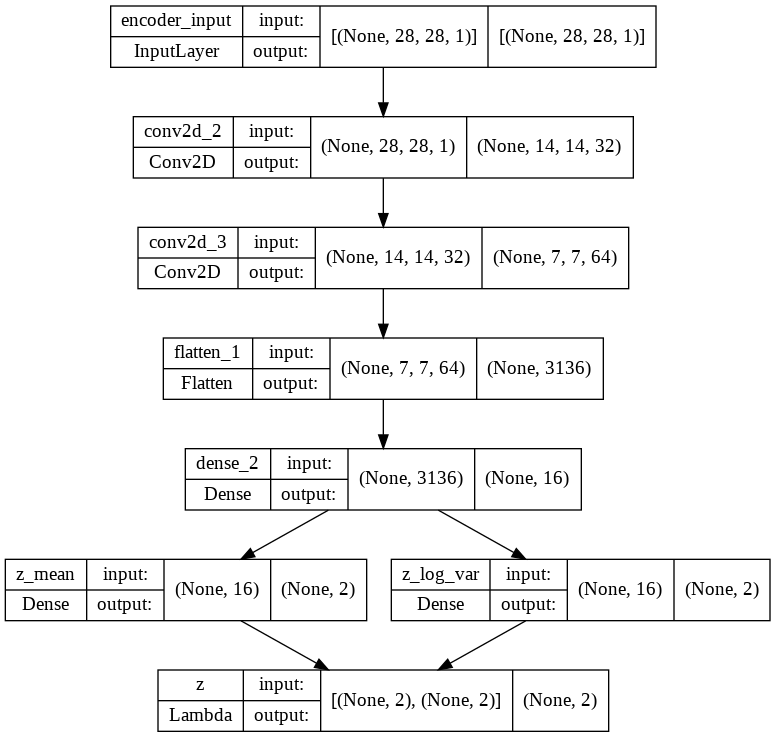

In [ ]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
# Lambda funcion para hacer wrapping 
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

### Decoder

In [ ]:

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289 

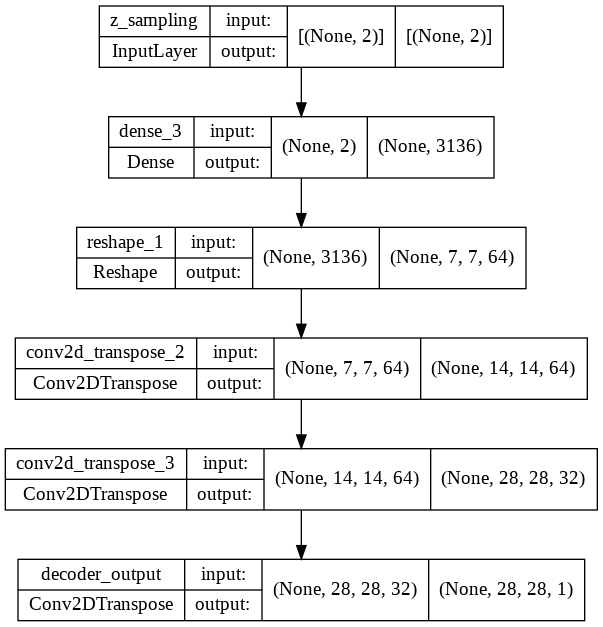

In [ ]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)


### VAE

<p align="justify">Normalmente, las dos redes involucradas, encoder y decoder, se entrenan simultáneamente como una unidad con el fin de acoplar el comportamiento de una al de la otra, y se usa la función de pérdida como mecanismo para dirigir este entrenamiento y conseguir que el error existente entre el original y la reproducción se vaya reduciendo (desde un punto de vista técnico, la función de pérdida es la función objetivo a minimizar).</p>

In [ ]:
# Cogemos la tercera salida del encoder, i.e. z
salida_enc = encoder(inputs)[2]
outputs = decoder(salida_enc)
vae = Model(inputs, outputs, name='vae')

In [ ]:
# VAE loss = rec_loc + kl_loss
# ELBO: https://xyang35.github.io/2017/04/14/variational-lower-bound/

# rec_loc
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss = reconstruction_loss * image_size * image_size

# kl_loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# VAE loss
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compilar modelo con la nueva loss
vae.compile(optimizer='rmsprop')
vae.summary()
#plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          69076       ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    65089       ['encoder[0][2]']                
                                                                                                

## Entrenar

In [ ]:
# entrenar autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_cnn_mnist.h5')

Epoch 1/30
469/469 [==============================] - 116s 245ms/step - loss: 52.5427 - val_loss: 46.1584
Epoch 2/30
469/469 [==============================] - 104s 222ms/step - loss: 44.4689 - val_loss: 43.2600
Epoch 3/30
469/469 [==============================] - 106s 226ms/step - loss: 42.6956 - val_loss: 43.0263
Epoch 4/30
469/469 [==============================] - 107s 227ms/step - loss: 41.5877 - val_loss: 41.2998
Epoch 5/30
469/469 [==============================] - 104s 222ms/step - loss: 40.7979 - val_loss: 40.3612
Epoch 6/30
469/469 [==============================] - 105s 224ms/step - loss: 40.1880 - val_loss: 40.2163
Epoch 7/30
469/469 [==============================] - 103s 221ms/step - loss: 39.6990 - val_loss: 39.7499
Epoch 8/30
469/469 [==============================] - 102s 219ms/step - loss: 39.3094 - val_loss: 39.3463
Epoch 9/30
469/469 [==============================] - 102s 218ms/step - loss: 38.9769 - val_loss: 38.6503
Epoch 10/30
469/469 [=========================

## Plotear

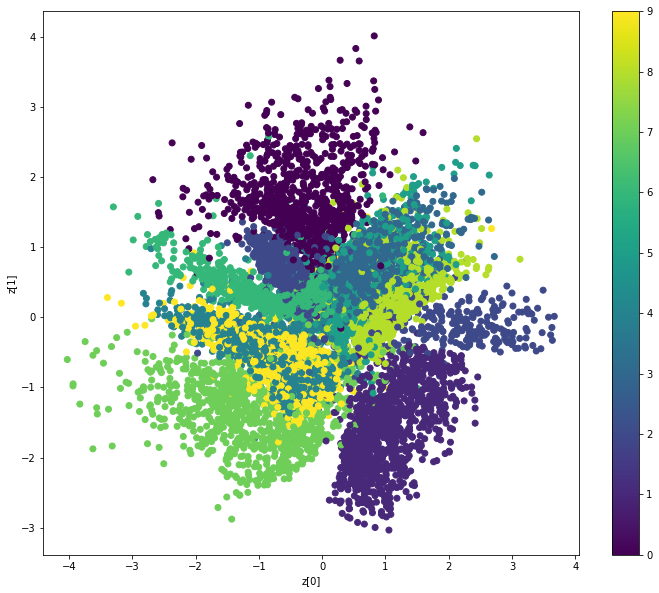

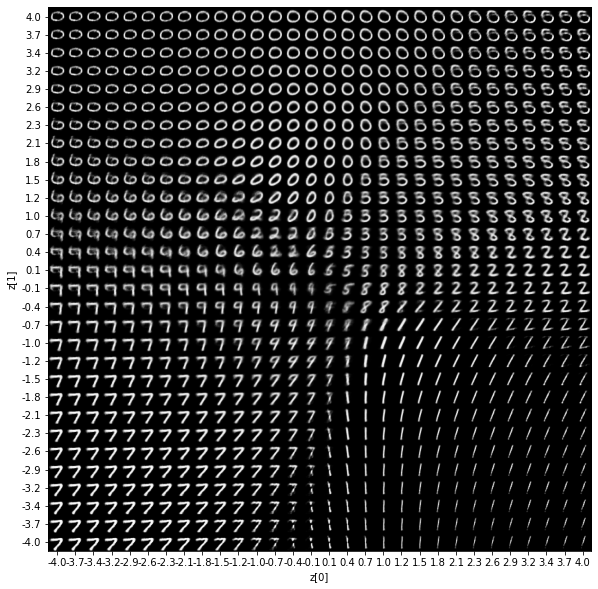

In [ ]:
data = (x_test, y_test)
models = (encoder, decoder)

plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")